# Policy gradients


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.3583326808380467 -3.291879242083139
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [32]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [33]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [34]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [43]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward): # model input
    # Policy gradients
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    #g_loss_p = tf.reduce_mean(neg_log_prob_actions * targetQs)
    #g_loss_p = tf.reduce_mean(neg_log_prob_actions * targetQs) * reward 
    #Qs_label = tf.reshape(0.01*targetQs[:-1]) + (0.99*targetQs[1:]), shape=[-1, 1])
    #Qs_label = tf.reshape(tf.nn.sigmoid(targetQs[:-1]) + (0.99*targetQs[1:]), shape=[-1, 1])
    #g_loss_p = tf.reduce_mean(neg_log_prob_actions * Qs_label) * reward 
    # reward/rate = episode_total_reward/goal_total_reward --> success/fail rate of episode
    
    # Adv training
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                    labels=reward*tf.ones_like(Qs_logits)))
    # Q-learning & Policy gradients
    #targetQs[-1] is 0 meaning total rewards are 0
    g_loss = tf.reduce_mean((neg_log_prob_actions[:-1] * targetQs[:-1]) +
                            tf.square(Qs_logits[:-1] - targetQs[1:]))
    #g_loss_q = tf.reduce_mean(tf.square(Qs_logits[:-1]-targetQs[1:]))
    #g_loss_q = tf.reduce_mean(tf.square(Qs_logits[:-1]-Qs_label))
    # g_loss_q = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits[:-1],
    #                                                                   labels=tf.nn.sigmoid(Qs_label)))
    #g_loss = g_loss_p + g_loss_q
    return actions_logits, Qs_logits, g_loss, d_loss#, g_loss_p, g_loss_q

In [44]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [45]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, reward=self.reward, targetQs=self.targetQs) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [46]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(10, 4) actions:(10,)
action size:1


In [47]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [48]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [49]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [52]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

# Now train with experiences
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(11111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run([model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            #targetQ = Q_logits * (1-float(done)) # Only for INFO
            #state = next_state
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # success criteria
                success_rate = total_reward/200 # success rate
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, _, _ = sess.run([model.g_loss, model.d_loss, 
                                         model.g_opt, model.d_opt],
                                        feed_dict = {model.states: states, 
                                                     model.actions: actions,
                                                     model.reward: success_rate,
                                                     model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              #'stdR:{:.4f}'.format(np.std(episodes_total_reward)),
              #'glossP:{:.4f}'.format(g_loss_p),
              #'glossQ:{:.4f}'.format(g_loss_q),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 200:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:73.0000 gloss:0.0014 dloss:0.6935
Episode:1 meanR:71.5000 gloss:-0.0193 dloss:0.6889
Episode:2 meanR:62.3333 gloss:-0.0286 dloss:0.6817
Episode:3 meanR:62.2500 gloss:-0.0622 dloss:0.6764
Episode:4 meanR:62.2000 gloss:-0.1084 dloss:0.6651
Episode:5 meanR:53.5000 gloss:-0.1522 dloss:0.5852
Episode:6 meanR:47.2857 gloss:-0.1724 dloss:0.5633
Episode:7 meanR:42.8750 gloss:-0.1868 dloss:0.5715
Episode:8 meanR:40.1111 gloss:-0.1903 dloss:0.5830
Episode:9 meanR:43.2000 gloss:-0.1835 dloss:0.6620
Episode:10 meanR:41.4545 gloss:-0.1906 dloss:0.5922
Episode:11 meanR:44.5833 gloss:-0.2132 dloss:0.6732
Episode:12 meanR:44.9231 gloss:-0.1769 dloss:0.6348
Episode:13 meanR:44.7143 gloss:-0.2572 dloss:0.5930
Episode:14 meanR:44.2000 gloss:-0.2651 dloss:0.5698
Episode:15 meanR:43.2500 gloss:-0.3223 dloss:0.5440
Episode:16 meanR:43.1765 gloss:-0.1262 dloss:0.5898
Episode:17 meanR:42.8333 gloss:0.0499 dloss:0.5733
Episode:18 meanR:42.8947 gloss:0.0903 dloss:0.5940
Episode:19 meanR:43.1500 

Episode:159 meanR:24.6400 gloss:-1.5019 dloss:0.9832
Episode:160 meanR:25.6400 gloss:-1.5257 dloss:1.4999
Episode:161 meanR:26.4700 gloss:-1.4601 dloss:1.1550
Episode:162 meanR:26.8000 gloss:-1.3807 dloss:0.5564
Episode:163 meanR:27.0600 gloss:-1.3115 dloss:0.4866
Episode:164 meanR:27.4900 gloss:-1.2348 dloss:0.6371
Episode:165 meanR:27.6600 gloss:-1.1852 dloss:0.3972
Episode:166 meanR:27.8200 gloss:-1.1045 dloss:0.5399
Episode:167 meanR:28.1000 gloss:-1.0381 dloss:0.5113
Episode:168 meanR:28.1600 gloss:-0.9695 dloss:0.3843
Episode:169 meanR:28.4300 gloss:-0.9373 dloss:0.5149
Episode:170 meanR:28.4100 gloss:-0.9239 dloss:0.3222
Episode:171 meanR:28.5600 gloss:-0.8694 dloss:0.4238
Episode:172 meanR:28.6300 gloss:-0.8662 dloss:0.3924
Episode:173 meanR:28.7100 gloss:-0.8884 dloss:0.3613
Episode:174 meanR:28.7100 gloss:-0.9219 dloss:0.3269
Episode:175 meanR:28.7400 gloss:-0.8998 dloss:0.3200
Episode:176 meanR:28.7400 gloss:-0.9055 dloss:0.2598
Episode:177 meanR:28.5900 gloss:-0.9378 dloss:

Episode:315 meanR:49.4300 gloss:-0.8274 dloss:3.3576
Episode:316 meanR:50.4900 gloss:-0.5674 dloss:1.2417
Episode:317 meanR:50.5800 gloss:-0.6129 dloss:0.5871
Episode:318 meanR:50.2700 gloss:-0.7723 dloss:0.4159
Episode:319 meanR:50.0900 gloss:-0.7405 dloss:0.3801
Episode:320 meanR:49.8500 gloss:-0.7113 dloss:0.3680
Episode:321 meanR:49.7600 gloss:-0.6835 dloss:0.3434
Episode:322 meanR:49.5800 gloss:-0.3792 dloss:0.3091
Episode:323 meanR:49.3800 gloss:-0.4823 dloss:0.3220
Episode:324 meanR:49.3100 gloss:-0.5803 dloss:0.4065
Episode:325 meanR:49.3200 gloss:-0.5152 dloss:0.4449
Episode:326 meanR:49.4900 gloss:-0.4152 dloss:0.5246
Episode:327 meanR:50.4000 gloss:-0.3867 dloss:0.7490
Episode:328 meanR:55.2100 gloss:-0.3926 dloss:1.8812
Episode:329 meanR:55.6500 gloss:-0.3444 dloss:0.6237
Episode:330 meanR:55.7800 gloss:-0.2971 dloss:0.5214
Episode:331 meanR:55.7400 gloss:-0.3274 dloss:0.4452
Episode:332 meanR:55.7200 gloss:-0.3377 dloss:0.4595
Episode:333 meanR:55.8400 gloss:-0.2811 dloss:

Episode:472 meanR:21.6100 gloss:-0.6613 dloss:0.2287
Episode:473 meanR:22.2000 gloss:-0.6042 dloss:0.6777
Episode:474 meanR:22.2100 gloss:-0.2887 dloss:0.2791
Episode:475 meanR:23.6400 gloss:-0.6220 dloss:1.0766
Episode:476 meanR:24.2900 gloss:-0.4722 dloss:0.6932
Episode:477 meanR:24.3700 gloss:-0.7948 dloss:0.3430
Episode:478 meanR:24.3800 gloss:-0.7599 dloss:0.2814
Episode:479 meanR:24.4100 gloss:-0.8101 dloss:0.2941
Episode:480 meanR:24.4400 gloss:-0.7693 dloss:0.3017
Episode:481 meanR:24.5300 gloss:-0.7738 dloss:0.3737
Episode:482 meanR:24.7500 gloss:-0.5159 dloss:0.4726
Episode:483 meanR:24.8200 gloss:-0.7886 dloss:0.3566
Episode:484 meanR:24.8600 gloss:-0.8309 dloss:0.3096
Episode:485 meanR:24.8700 gloss:-0.6808 dloss:0.2761
Episode:486 meanR:24.8700 gloss:-0.6244 dloss:0.2651
Episode:487 meanR:25.6700 gloss:-0.4499 dloss:0.7540
Episode:488 meanR:25.9700 gloss:-0.4968 dloss:0.5338
Episode:489 meanR:25.9300 gloss:-0.5310 dloss:0.3432
Episode:490 meanR:25.8800 gloss:-0.6031 dloss:

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

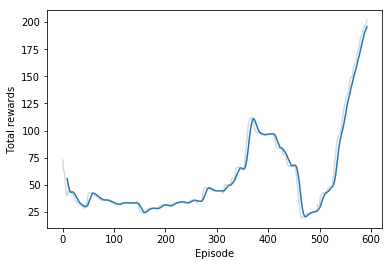

In [54]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

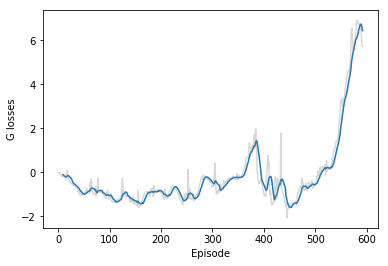

In [55]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

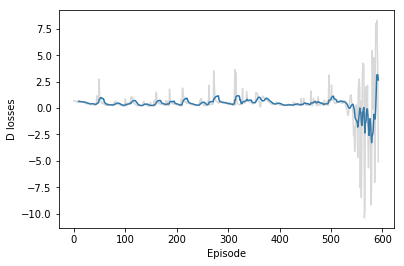

In [56]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [57]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        if total_reward == 500:
            break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 247.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.